<a href="https://colab.research.google.com/github/dinooooooi/dinooooi/blob/main/1218_%EC%9B%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##03.평균 이동

###평균이동의 개요

: k-평균과 유사하게 중심을 군집의 중심으로 지속적으로 움직이면서 군집화 수행/ 중심- 데이터가 모여 있는 밀도가 가장 높은 곳

확률 밀도 함수로 군집 중심점 찾음 KDE(Kernel Density Estimation) 이용

주변 데이터와의 거리 값을 KDE 함수 값으로 입력한 뒤 그 반환 값을 현재 위치에서 업데이트하면서 이동하는 방식

커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 방법, 개별 관측 데이터에 커널 함수(가우시안 분포 함수)로 적용한 뒤 이 적용 값을 모두 더한 후 개별 관측 데이터의 건수로 나눠 확률 밀도 함수 추정


커널함수의 h 대여폭은 부드러운 형태로 평활화함 작으면 좁고 뾰족한 KDE - 과적합/ 크면 과소적합


확률 밀도함수 PDF = 확률 변수의 분포 나타냄 변수의 특성, 확률 분포 등 변수의 많은 요소 알 수 있음

최적의 대여폭 계산을 위해 estimate_bandwidth()함수

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

X,y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2 3 4 5]


In [2]:
#1.0으로 높여서 meanshift 수행
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


In [3]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


In [4]:
#1.816으로 군집화 수행
import pandas as pd
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

#estimate_bandwidth()로 최적의 bandwidth 계산
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth=best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels유형:', np.unique(cluster_labels))

cluster labels유형: [0 1 2]


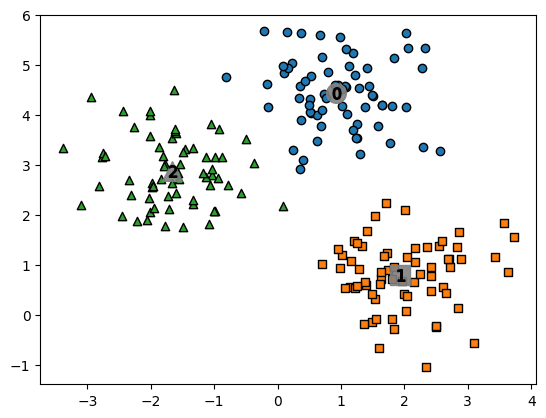

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

clusterDF['meanshift_label']=cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers=['o', 's', '^', 'x', '*']

for label in unique_labels:
  label_cluster = clusterDF[clusterDF['meanshift_label']==label]
  center_x_y = centers[label]

  #군집별로 다른 마커로 산점도 적용
  plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], edgecolor='k', marker=markers[label])

  #군집별 중심 표현
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=200, color='gray', alpha=0.9, marker=markers[label])
  plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k', edgecolor='k', marker='$%d$' % label)

plt.show()

In [6]:
print(clusterDF.groupby('target')['meanshift_label'].value_counts())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
Name: meanshift_label, dtype: int64


데이터 세트의 형태를 특정 형태로 가정하고 특정 분포도 기반의 모델로 가정하지 않기 때문에 좀 더 유연한 군집화 가능, 이상치의 영향력 크지 않고 미리 군집의 개수 정할 필요 없음

수행 시간 오래 걸리고 bandwidth 크기에 따른 군집화 영향도가 큼 -> 컴퓨터 비전 영역에서 많이 사용, 이미지 영상 데이터에서 뛰어난 역할 수행

##GMM

###GMM 소개

GMM군집화는 군집화를 적용하고자 하는 데이터가 여러 개의 가우시안 분포를 가진 데이터 집합들이 섞여서 생성된 것이라는 가정 하에 군집화를 수행

가우시안 분포 = 좌우 대칭형의 종 형태를 가진 연속 확률 함수 / 정규 분포

GMM은 여러 개의 가우시안 분포가 섞인 데이터, 여러 개의 정규 분포 곡선을 추출하고 개별 데이터가 어떤 정규 분포에 속하는지 결정하는 방식 = 모수추정(개별 정규 분포의 평균과 분산, 각 데이터가 어떤 정규 분포에 해당되는지의 확률) -EM방법 적용

### GMM을 이용한 붓꽃 데이터 세트 군집화

확률 기반 군집화



In [8]:
from ast import increment_lineno
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
iris = load_iris()
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

#좀 더 편리한 데이터 handling을 위해 DataFrame으로 변환
irisDF = pd.DataFrame(data=iris.data, columns=feature_names)
irisDF['target']=iris.target

In [10]:
#n_components 초기화 파라미터를 3으로 설정해 GaussianMixture 군집화 수행
#GaussianMixture 객체의 fit와 predict를 수행해 군집 결정한 뒤 irisDF DataFrame에 'gmm_cluster'칼럼 명으로 저장

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(iris.data)
gmm_cluster_labels = gmm.predict(iris.data)

#군집화 결과를 irisDF의 'gmm_cluster' 칼럼 명으로 저장
irisDF['gmm_cluster']=gmm_cluster_labels
irisDF['target']=iris.target

#target값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인
iris_result = irisDF.groupby(['target'])['gmm_cluster'].value_counts()
print(iris_result)

target  gmm_cluster
0       0              50
1       2              45
        1               5
2       1              50
Name: gmm_cluster, dtype: int64


In [12]:
#k-평균 군집화 수행
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, random_state=0).fit(iris.data)
kmeans_cluster_labels = kmeans.predict(iris.data)
irisDF['kmeans_cluster']=kmeans_cluster_labels
iris_result = irisDF.groupby(['target'])['kmeans_cluster'].value_counts()
print(iris_result)

target  kmeans_cluster
0       1                 50
1       0                 48
        2                  2
2       2                 36
        0                 14
Name: kmeans_cluster, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##GMM과 K-평균의 비교

kmeans는 원형의 범위에서 군집화 수행
원형의 범위를 가질수록 kmeans의 군집화 효율이 높아짐

데이터가 원형의 범위로 퍼져있지 않는 경우에 make_blobs의 데이터를 변환해 만듦

In [17]:
from sklearn.datasets import make_blobs
#make_blobs()로 300개의 데이터 세트, 3개의 군집 세트, cluster_std=0.5를 만듦
X,y = make_blobs(n_samples=300, n_features=2, centers=3, cluster_std=0.5, random_state=0)

#길게 늘어난 타원형의 데이터 세트를 세트를 생성하기 위해 변환함
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
#feature 데이터 세트와 make_blobs()의 y결과값을 DataFrame으로 저장
clusterDF = pd.DataFrame(data=X_aniso, columns=['ftr1', 'ftr2'])
clusterDF['target']=y
#생성된 데이터 세트를 target별로 다른 마커로 표시해 시각화함
#visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

In [18]:
#3개의 군집 기반 Kmeans를 X_aniso 데이터 세트에 적용
kmeans = KMeans(3, random_state=0)
kmeans_label = kmeans.fit_predict(X_aniso)
clusterDF['kmeans_label'] = kmeans_label
#visualize_cluster_plot(kmeans, clusterDF, 'kmeans_label', iscluster=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [19]:
#3개의 n_components 기반 GMM을 X_aniso 데이터 세트에 적용
gmm = GaussianMixture(n_components=3, random_state=0)
gmm_label = gmm.fit(X_aniso).predict(X_aniso)
clusterDF['gmm_label']= gmm_label

#GaussianMixture는 cluster_centers_속성이 없으므로 iscluster를 False로 설정
#visualize_cluster_plot(gmm, clusterDF, 'gmm_label', iscluster=True)

In [20]:
print('###KMeans Clustering###')
print(clusterDF.groupby('target')['kmeans_label'].value_counts())
print('\n### Gaussian Mixture Clustering###')
print(clusterDF.groupby('target')['gmm_label'].value_counts())

###KMeans Clustering###
target  kmeans_label
0       2                73
        0                27
1       1               100
2       0                86
        2                14
Name: kmeans_label, dtype: int64

### Gaussian Mixture Clustering###
target  gmm_label
0       2            100
1       1            100
2       0            100
Name: gmm_label, dtype: int64
